___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2025

___
### Import libraries and sub-libraries.

In [38]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import torch.nn.functional as F
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
# You can install torchmeterics using: pip install torchmetrics

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [39]:
#from fontsetting import font_cmu
#plt = font_cmu(plt)
# Disable LaTeX
#plt.rcParams['text.usetex'] = False

___
### Check and set hardware (CUDA vs CPU)

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)


Device available: cuda


___
### Read training data from `data/train/hig-res` and `data/train/low-res`


In [41]:
# Loading TIFF images for Super-resolution
class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, transform=None):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.transform = transform
        self.filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
    
    # Get the number of samples in the dataset
    def __len__(self):
        return len(self.filenames)

    # Get the sample at the given index
    def __getitem__(self, idx):
        high_res_path = os.path.join(self.high_res_dir, self.filenames[idx])
        low_res_path = os.path.join(self.low_res_dir, self.filenames[idx])

        # Load images
        high_res = Image.open(high_res_path)
        low_res = Image.open(low_res_path)

        # Resize low-res to 128x128 (ensuring correct input size)
        low_res = low_res.resize((128, 128), Image.BICUBIC)
        high_res = high_res.resize((256, 256), Image.BICUBIC)  # testing this line

        # Apply transformations
        if self.transform:
            high_res = self.transform(high_res)
            low_res = self.transform(low_res)

        return low_res, high_res  # Returning input-output pairs

# Define a transform to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('data/train/high-res', 'data/train/low-res', transform=transform)

# Function to create data loader
def create_loader(dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print dataset size
dataset_size = len(train_dataset)
print('Number of images in the dataset:', dataset_size)


Number of images in the dataset: 240


___
### define a super-resolution network

In [42]:
import torch.nn.functional as F

class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UNetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNetBaseline(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNetBaseline, self).__init__()

        self.enc1 = UNetBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = UNetBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = UNetBlock(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = UNetBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = UNetBlock(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.out_activation = nn.Sigmoid()

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))

        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.out_activation(self.final_conv(d1))


# class ResidualBlock(nn.Module):
#     def __init__(self, channels):
#         super(ResidualBlock, self).__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(channels)
#         )

#     def forward(self, x):
#         return x + self.block(x)

# class UNetEnhancedLite(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNetEnhancedLite, self).__init__()

#         # Encoder
#         self.down_conv1 = nn.Sequential(
#             nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             ResidualBlock(32),
#             nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)  # Downsample
#         )

#         # Bottleneck
#         self.bottleneck = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             ResidualBlock(64)
#         )

#         # Upsample
#         self.upsample = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)

#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Conv2d(64, 32, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(32, out_channels, kernel_size=3, padding=1)
#         )

#     def forward(self, x):
#         x1 = self.down_conv1(x)  # Downsampled feature
#         x2 = self.bottleneck(x1)  # Bottleneck
#         x3 = self.upsample(x2)    # Upsampled

#         # Match shapes for concat
#         if x3.shape[2:] != x1.shape[2:]:
#             x1 = F.interpolate(x1, size=x3.shape[2:], mode='bilinear', align_corners=False)

#         x_cat = torch.cat([x3, x1], dim=1)
#         out = self.decoder(x_cat)
#         return out
    
  


# class ResidualBlock(nn.Module):
#     def __init__(self, channels):
#         super(ResidualBlock, self).__init__()
#         self.block = nn.Sequential(
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1),
#             nn.GroupNorm(8, channels),
#             nn.GELU(),
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1),
#             nn.GroupNorm(8, channels)
#         )

#     def forward(self, x):
#         return x + self.block(x)

# class UNetEnhancedv2(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(UNetEnhancedv2, self).__init__()

#         # Encoder
#         self.down_conv1 = nn.Sequential(
#             nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
#             nn.GELU(),
#             ResidualBlock(64),
#             nn.Dropout(0.1),  # Moved dropout here
#             nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
#         )

    #     # Bottleneck
    #     self.bottleneck = nn.Sequential(
    #         nn.Conv2d(64, 128, kernel_size=3, padding=1),
    #         nn.GELU(),
    #         nn.Dropout(0.1),  # Moved dropout here
    #         ResidualBlock(128)
    #     )

    #     # Upsample
    #     self.upsample = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

    #     # Decoder
    #     self.decoder = nn.Sequential(
    #         nn.Conv2d(128, 64, kernel_size=3, padding=1),
    #         nn.GELU(),
    #         nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
    #         # Removed final Sigmoid/Tanh — output raw
    #     )

    # def forward(self, x):
    #     x1 = self.down_conv1(x)
    #     x2 = self.bottleneck(x1)
    #     x3 = self.upsample(x2)

    #     if x3.shape[2:] != x1.shape[2:]:
    #         x1 = F.interpolate(x1, size=x3.shape[2:], mode='bilinear', align_corners=False)

    #     x_cat = torch.cat([x3, x1], dim=1)
    #     out = self.decoder(x_cat)
    #     return out


___
### custom loss function and function to execute training

In [43]:
from pytorch_msssim import SSIM
import torchmetrics.functional as tmf
from torchmetrics.functional import structural_similarity_index_measure as ssim
import time

def psnr_loss(pred, target, data_range=1.0):
    # Compute MSE between the predicted and target
    mse = F.mse_loss(pred, target)
    # Compute PSNR
    psnr = 10 * torch.log10((data_range**2) / mse)
    return -psnr  # We negate PSNR since we minimize loss

def hybrid_loss(output, target, alpha=0.7, beta=0.1, psnr_weight=0.5):
    # SSIM component
    ssim_component = 1 - tmf.structural_similarity_index_measure(output, target, data_range=1.0)
    # PSNR component
    psnr_component = psnr_loss(output, target)
    # L1 component
    l1_component = F.l1_loss(output, target)
    # Gradient component (you can keep this part if needed)
    grad_component = gradient_loss(output, target)
    
    # Combine the components with respective weights
    loss = (alpha * l1_component + 
            (1 - alpha) * ssim_component + 
            psnr_weight * psnr_component + 
            beta * grad_component)
    return loss

def gradient_loss(output, target):
    grad_output_x = output[:, :, :, :-1] - output[:, :, :, 1:]
    grad_target_x = target[:, :, :, :-1] - target[:, :, :, 1:]
    grad_output_y = output[:, :, :-1, :] - output[:, :, 1:, :]
    grad_target_y = target[:, :, :-1, :] - target[:, :, 1:, :]
    return F.l1_loss(grad_output_x, grad_target_x) + F.l1_loss(grad_output_y, grad_target_y)

def train_model(model, train_loader, optimizer, num_epochs=30, save_path='checkpoint.pth'):
    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        start_time = time.time()

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            y_hat = model(x)
            loss = hybrid_loss(y_hat, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        scheduler.step()
        print(f"[Epoch {epoch+1}] Loss: {epoch_loss/len(train_loader):.4f} | Time: {time.time() - start_time:.1f}s")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, save_path)



# class SSIM_L1_Loss(nn.Module):
#     def __init__(self, alpha=0.5):
#         super(SSIM_L1_Loss, self).__init__()
#         self.alpha = alpha
#         self.ssim = SSIM(data_range=1.0, size_average=True, channel=1)
#         self.l1 = nn.L1Loss()

#     def forward(self, pred, target):
#         pred = torch.clamp(pred, 0.0, 1.0)
#         target = torch.clamp(target, 0.0, 1.0)

#         # Downsample for SSIM only
#         pred_ssim = F.interpolate(pred, scale_factor=0.5, mode='bilinear', align_corners=False)
#         target_ssim = F.interpolate(target, scale_factor=0.5, mode='bilinear', align_corners=False)

#         ssim_loss = 1 - self.ssim(pred_ssim, target_ssim)
#         l1_loss = self.l1(pred, target) 

#         return self.alpha * ssim_loss + (1 - self.alpha) * l1_loss
    



def train_model(model, opt, criterion, train_loader, num_epoch):
    avg_train_losses = []

    for epoch in range(num_epoch):  # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0

        for i, (x_tr_batch, y_tr_batch) in enumerate(train_loader):  # Loop over mini-batches
            x_tr_batch, y_tr_batch = x_tr_batch.to(device), y_tr_batch.to(device)

            # Upsample low-resolution input to 256x256
            x_tr_batch = torch.nn.functional.interpolate(x_tr_batch, scale_factor=2, mode='bicubic', align_corners=False)

            opt.zero_grad()  # Delete previous gradients
            y_hat_tr_batch = model(x_tr_batch)  # Forward pass
            loss = criterion(y_hat_tr_batch, y_tr_batch)  # Compute loss
            loss.backward()  # Backward pass
            opt.step()  # Update weights
            total_train_loss += loss.item()  # Accumulate loss
      

            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader)  # Compute average loss
        avg_train_losses.append(avg_train_loss)  # Store average loss
    torch.cuda.empty_cache() # see if emptying cache helps with oom

    # Plot training loss
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(1, num_epoch + 1), avg_train_losses, label='training loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('SSIM+L1 loss')
    ax.set_yscale('log')  # Log scale for better visualization
    ax.set_title('training loss')
    ax.grid(True)
    ax.legend()
    plt.show()

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

c:\Users\keher\Downloads\ML-homework\BME5710-FinalProject\venv\Lib\site-packages\torchmetrics\utilities\prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Epoch 1, Iteration 10, Loss: -5.158438
Epoch 1, Iteration 20, Loss: -6.406007
Epoch 1, Iteration 30, Loss: -6.879276
Epoch 1, Iteration 40, Loss: -7.530843
Epoch 2, Iteration 10, Loss: -7.853498
Epoch 2, Iteration 20, Loss: -8.123504
Epoch 2, Iteration 30, Loss: -7.428778
Epoch 2, Iteration 40, Loss: -8.086307
Epoch 3, Iteration 10, Loss: -8.012467
Epoch 3, Iteration 20, Loss: -9.892793
Epoch 3, Iteration 30, Loss: -9.260239
Epoch 3, Iteration 40, Loss: -9.864913
Epoch 4, Iteration 10, Loss: -9.448015
Epoch 4, Iteration 20, Loss: -10.063308
Epoch 4, Iteration 30, Loss: -9.403895
Epoch 4, Iteration 40, Loss: -10.653524
Epoch 5, Iteration 10, Loss: -10.288009
Epoch 5, Iteration 20, Loss: -10.770523
Epoch 5, Iteration 30, Loss: -11.118171
Epoch 5, Iteration 40, Loss: -10.274486
Epoch 6, Iteration 10, Loss: -10.778925
Epoch 6, Iteration 20, Loss: -12.179957
Epoch 6, Iteration 30, Loss: -11.520098
Epoch 6, Iteration 40, Loss: -12.101340
Epoch 7, Iteration 10, Loss: -11.500217
Epoch 7, Itera

C:\Users\keher\AppData\Local\Temp\ipykernel_24072\4177317886.py:125: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')  # Log scale for better visualization


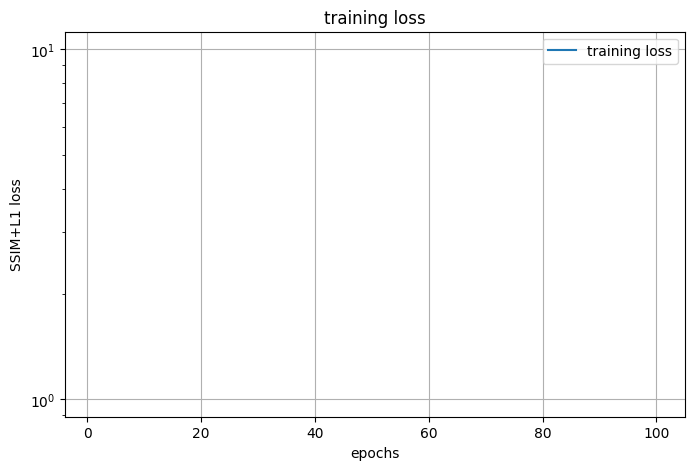

In [44]:
batch_size = 5  # Number of complete images in each batch
lr = 1e-3  # Learning rate
num_epoch = 100  # Epochs

model = UNetBaseline().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

#train_model(model, train_loader, optimizer, num_epochs=30)


# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
model = UNetBaseline().to(device)
#model = UNetEnhancedLite(in_channels=1, out_channels=1).to(device) # see if this helps gradient problem from below UNetEnhanced
#model = UNetEnhancedv2(in_channels=1, out_channels=1).to(device) # see if this helps gradient problem from below UNetEnhanced
#model = UNetEnhanced(in_channels=1, out_channels=1).to(device) # test U-Net instead of TrivialNet
#model = UNetSuperRes(in_channels=1, out_channels=1).to(device) # test U-Net instead of TrivialNet
#model = UNet(in_channels=1, out_channels=1).to(device) # test U-Net instead of TrivialNet
#model = TrivialNet().to(device)  # Pick a model and move to GPU/CPU
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
#opt = optim.Adam(model.parameters(), lr=lr)  # Pick an optimizer
criterion = lambda output, target: hybrid_loss(output, target, alpha=0.9)
#criterion = SSIM_L1_Loss(alpha=0.5)  # Pick a loss function (MSE or SSIM+L1)

# Train the model
train_model(model, opt, criterion, train_loader, num_epoch)
#train_model(model, opt, criterion, train_loader, num_epoch)

___
### Apply it one of the validation image

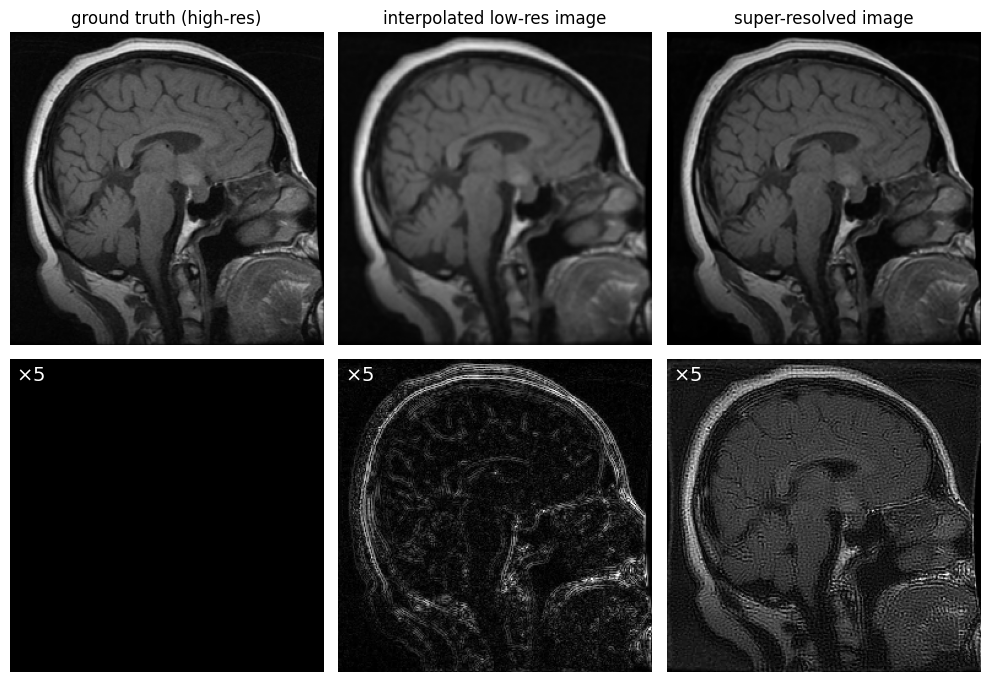

In [45]:
# Create the dataset for validation images
val_dataset = TIFFDataset('data/val/high-res', 'data/val/low-res', transform=transform)

# Load one (low-res, high-res) image pair from validation dataset and move it to the device
val_low_res, val_high_res = val_dataset[1]  # Input (128x128), Ground truth (256x256)
val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

# Upsample low-resolution image to 256x256 for both model input and error visualization
val_low_res_interpolated = torch.nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False).squeeze(0)

# Apply the trained model to super-resolve the interpolated low-res image
val_super_res = model(val_low_res_interpolated.unsqueeze(0)).detach().squeeze(0)  # Remove batch dimension

# Convert tensors to numpy for visualization
val_low_res_np = val_low_res_interpolated.squeeze().cpu().numpy()  # Use the interpolated version for error maps
val_high_res_np = val_high_res.squeeze().cpu().numpy()
val_super_res_np = val_super_res.squeeze().cpu().numpy()

# Plot an example image and error maps
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot images
ax[0, 0].imshow(val_high_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('ground truth (high-res)')
ax[0, 0].axis('off')

ax[0, 1].imshow(val_low_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('interpolated low-res image')
ax[0, 1].axis('off')

ax[0, 2].imshow(val_super_res_np, cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('super-resolved image')
ax[0, 2].axis('off')

# Error maps
ax[1, 0].imshow(5 * np.abs(val_high_res_np - val_high_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(5 * np.abs(val_high_res_np - val_low_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(5 * np.abs(val_high_res_np - val_super_res_np), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 5$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')

plt.tight_layout()
plt.show()


### Compute PSNR and SSIM over the entire validation dataset

In [46]:
# Initialize metrics
psnr_metric = PeakSignalNoiseRatio().to(device) # rewrite
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

# Accumulators
total_psnr_interpolated = 0
total_psnr_super_resolved = 0
total_ssim_interpolated = 0
total_ssim_super_resolved = 0
num_samples = len(val_dataset)

# Loop over validation set
for i in range(num_samples):
    val_low_res, val_high_res = val_dataset[i]
    val_low_res, val_high_res = val_low_res.to(device), val_high_res.to(device)

    # Compute data range dynamically
    data_range = val_high_res.max() - val_high_res.min()
    ssim_metric.data_range = data_range

    # Upsample low-res image
    val_low_res_up = torch.nn.functional.interpolate(val_low_res.unsqueeze(0), scale_factor=2, mode='bicubic', align_corners=False)
    val_high_res = val_high_res.unsqueeze(0)  # Add batch dim
    val_super_res = model(val_low_res_up).detach()

    # PSNR
    psnr_interp = psnr_metric(val_low_res_up, val_high_res).item()
    psnr_sr = psnr_metric(val_super_res, val_high_res).item()

    # SSIM (data_range is now set in metric initialization)
    ssim_interp = ssim_metric(val_low_res_up, val_high_res).item()
    ssim_sr = ssim_metric(val_super_res, val_high_res).item()

    # Accumulate
    total_psnr_interpolated += psnr_interp
    total_psnr_super_resolved += psnr_sr
    total_ssim_interpolated += ssim_interp
    total_ssim_super_resolved += ssim_sr

# Averages
avg_psnr_interp = total_psnr_interpolated / num_samples
avg_psnr_sr = total_psnr_super_resolved / num_samples
avg_ssim_interp = total_ssim_interpolated / num_samples
avg_ssim_sr = total_ssim_super_resolved / num_samples

# Print results
print(f'Average PSNR (interpolated): {avg_psnr_interp:.2f} dB')
print(f'Average PSNR (super-resolved): {avg_psnr_sr:.2f} dB')
print(f'Average SSIM (interpolated): {avg_ssim_interp:.4f}')
print(f'Average SSIM (super-resolved): {avg_ssim_sr:.4f}')
print(avg_psnr_sr+40*avg_ssim_sr)
#print(f'Average SSIM (super-resolved): {avg_ssim_sr:.4f}')

Average PSNR (interpolated): 30.81 dB
Average PSNR (super-resolved): 31.07 dB
Average SSIM (interpolated): 0.9056
Average SSIM (super-resolved): 0.9082
67.39713381131489
